## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 2: Multilayer Perceptron (MLP)
You will get to know how to build basic fully connected neural network.

In [7]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import time
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [8]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Basic layers
In this part, all the functions will be created from scratch using numpy for better understanding. (In the next task, you will be introduced to built in layers from TensorFlow.)

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./utils/layer_funcs.py**.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [7]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function: H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## check your implementation using the tf.gradients_function()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check, dw_check, db_check = dx_tf.numpy(), dw_tf.numpy(), db_tf.numpy()

## Print validation results
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./utils/layer_funcs.py**.


<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [8]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)

## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    out_tf = tf.nn.relu(x_tf)
    grad_gt = tape.gradient(out_tf, x_tf)

out_check = out_tf.numpy()
dx_check = grad_gt.numpy()
## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./utils/layer_funcs.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [22]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,20)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

## check by tf.GradientTape.gradients()

x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')

with tf.GradientTape() as tape:
    tape.watch(x_tf)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,20))
    loss_tf = tf.reduce_mean(cross_entropy)
    dx_tf = tape.gradient(loss_tf, x_tf)

loss_check = loss_tf.numpy()
dx_check = dx_tf.numpy()
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))


Is loss correct? True
Is dx correct? True


### Create a single layer

Combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./utils/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./utils/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [25]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=X_train.shape[1],output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [26]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=X_train.shape[1],output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = dense_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: Two Layer Network

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [30]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=100, num_classes=20, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

## Check loss by tensorflow
x_tf = tf.Variable(X_dev, dtype = tf.float32)
y_tf = tf.Variable(y_dev, dtype = tf.uint8)

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf))
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,20))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss 

loss_check=loss_tf.numpy()
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [9]:
from utils.train_funcs import train, test

#### Start training
We have provide you the **train( )** function in **./utils/train_func.py**

In [6]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=400, num_classes=20, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.904699856678745
10000/49000 loss: 2.7580812424261802
15000/49000 loss: 2.7480565080199777
20000/49000 loss: 2.3447599589226558
25000/49000 loss: 2.2848031886456512
30000/49000 loss: 2.0993996327967306
35000/49000 loss: 1.8172352321811724
40000/49000 loss: 1.6027224640364581
45000/49000 loss: 1.321417047766227
epoch 1: valid acc = 0.55, new learning rate = 0.000475
5000/49000 loss: 1.1563177499860202
10000/49000 loss: 1.1485033562767735
15000/49000 loss: 1.0500552813170323
20000/49000 loss: 1.1102408142748215
25000/49000 loss: 1.1467559014743856
30000/49000 loss: 1.0181669411864358
35000/49000 loss: 0.9620823852771206
40000/49000 loss: 0.9692771929634455
45000/49000 loss: 0.9342468921272836
epoch 2: valid acc = 0.697, new learning rate = 0.00045125
5000/49000 loss: 0.8918111610763781
10000/49000 loss: 0.8622630493904988
15000/49000 loss: 0.7889820632792536
20000/49000 loss: 0.7972076225565224
25000/49000 loss: 0.7134805750077542
3000

0.83

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

<span style="color:red"><strong>Solution</strong></span>:

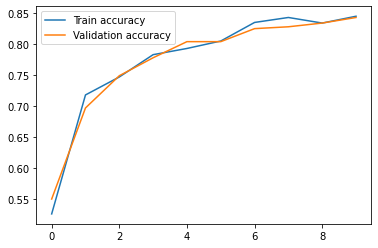

In [7]:
# plot the accuracy history
plt.plot(train_acc_hist, label="Train accuracy")
plt.plot(val_acc_hist, label="Validation accuracy")
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [9]:
from utils.display_funcs import visualize_pics

num of feature vectors: 400


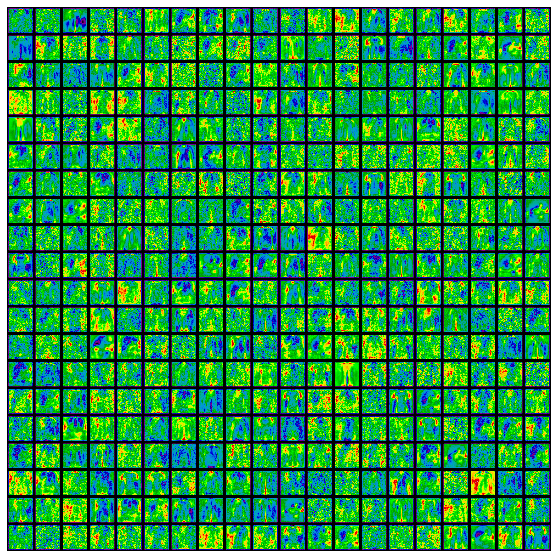

In [10]:
weights = model.layer1.params[0]
pics = weights.reshape(1, X_train_raw.shape[1], X_train_raw.shape[2], -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics, cmap='nipy_spectral')

### Get test accuracy greater than 80%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 35%. If your accuracy is lower, for each 1% lower than 35%, you will lose 1 point (There are totally 10 points for this part).

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```

<span style="color:red"><strong>TODO</strong></span>: See below

In [10]:
from utils.classifiers.twolayernet import TwoLayerNet
# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to the code below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)


<span style="color:red"><strong>Solution</strong></span>:

In [15]:
from utils.classifiers.twolayernet import TwoLayerNet
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=240, num_classes=10, reg=1e-5, weight_scale=1e-3)
num_epoch = 20

batch_size = 600
lr = 12e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                                     num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, optim='SGD', verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 81
6000/49000 loss: 2.193902260454304
12000/49000 loss: 1.867006912408789
18000/49000 loss: 1.7233943040294823
24000/49000 loss: 1.2328729484042522
30000/49000 loss: 1.1193186229703473
36000/49000 loss: 1.0044352503723566
42000/49000 loss: 0.8851867354967641
48000/49000 loss: 0.8877595851750378
epoch 1: valid acc = 0.728, new learning rate = 0.00114
6000/49000 loss: 0.7539467026487514
12000/49000 loss: 0.694157026619732
18000/49000 loss: 0.6744744407783123
24000/49000 loss: 0.670615542506808
30000/49000 loss: 0.5939824424586445
36000/49000 loss: 0.6394204875679604
42000/49000 loss: 0.6078086194755323
48000/49000 loss: 0.5494764777018208
epoch 2: valid acc = 0.783, new learning rate = 0.001083
6000/49000 loss: 0.5712511530090454
12000/49000 loss: 0.5604723935332823
18000/49000 loss: 0.5722436214554764
24000/49000 loss: 0.45257874115505814
30000/49000 loss: 0.49786757420736466
36000/49000 loss: 0.456888367586747
42000/49000 loss: 0.5484373349507452
48000/4

0.8615

#### <span style="color:red"><strong>TODO</strong></span>: Show your best results, including training plot of accuracy and loss and a visualization of weights.

<span style="color:red"><strong>Solution</strong></span>:

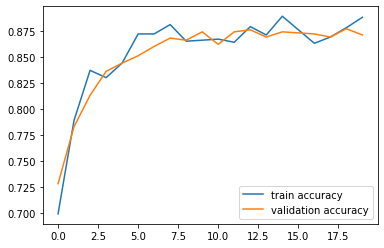

In [16]:
# training and accuracy plot
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

num of feature vectors: 160


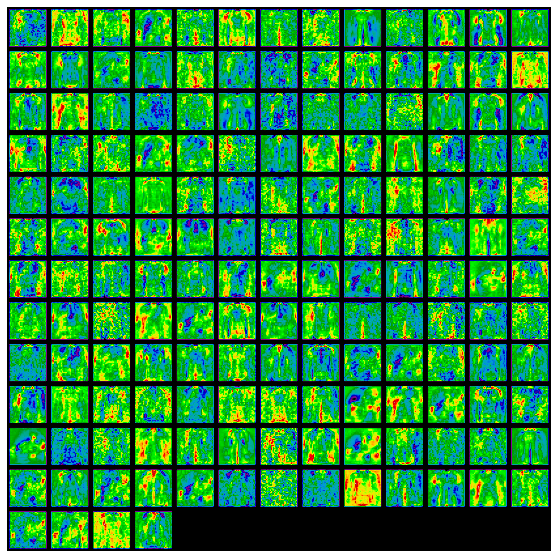

In [16]:
# visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(1, X_train_raw.shape[1], X_train_raw.shape[2], -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics, cmap='nipy_spectral')

### Save your best model in a dictionary 

In [17]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [18]:
## Load your model
with open("./save_models/best_model.pkl", "rb") as input_file:
    load_params = pickle.load(input_file)
    
model.update_model(load_params)

## Part 3: Multilayer Network

Complete the class **MLP** in **./utils/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete the class **MLP** in **./utils/classifiers/mlp.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [26]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                          #

from utils.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 100
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 490
epoch 1: valid acc = 0.789, new learning rate = 0.0095
epoch 2: valid acc = 0.848, new learning rate = 0.009025
epoch 3: valid acc = 0.86, new learning rate = 0.00857375
epoch 4: valid acc = 0.848, new learning rate = 0.0081450625
epoch 5: valid acc = 0.847, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.839, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.859, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.842, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.883, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.872, new learning rate = 0.005987369392383786
test acc: 0.8582


0.8582

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

<span style="color:red"><strong>Solution</strong></span>:

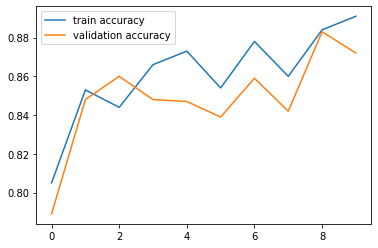

In [27]:
#TODO: plot training and validation accuracy
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()